# **Entrainement du modèle de détection des bâtiments détruits à partir du modèle Pré-entrainé sur la base euroSAT**

In [1]:
import os
import time
import copy

import tensorflow as tf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

On commence par sélectionner le device sur lequel les calculs seront effectués.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('%d GPU(s) disponible.' % torch.cuda.device_count())
    print('GPU utilisé :', torch.cuda.get_device_name(0))

else:
    print('Pas de GPU disponible, utilisation du CPU.')
    device = torch.device("cpu")

1 GPU(s) disponible.
GPU utilisé : GeForce GTX 1050 Ti


### **Création du `DataLoader`**

Le chargement des images par `PyTorch` nécessite la création d'un objet appelé `DataLoader`. Le `DataLoader` permet de charger les images par batch dans le device (et ne pas surcharger la RAM du GPU) et d'appliquer des transformations sur ces images lors de leur chargement.  
  
On commence par définir le dictionnaire `data_transforms` contenant les transformations à appliquer sur les images. Nous avons décidé d'appliquer les deux transformations:  
- `RandomHorizontalFlip` retourne avec une probabilité de 0.5 l'image par rapport à l'axe horizontal. Cette technique permet d'augmenter artificiellement notre volume de données.  
  
- `Normalize` permet de normaliser les images sur les 3 canaux RGB. Les valeurs des moyennes et écarts-types utilisés lors de la normalisation correspondent aux valeurs calculées sur les images du data set [ImageNet](http://image-net.org/download). Nous reprenons ces valeurs car les poids du CNN sont préalablemment entraînés sur ces images. (Voir le notebook *2_training_rgb.ipynb*, partie *Calcul des moyennes et écarts-type de nos images*, pour plus de détails)
  
  
Pour finir, le `batch_size` nous permet de fixer le nombre d'images à charger par batch. Ce paramètre est ajusté en fonction de la RAM du GPU sur lequel le modèle sera amené à tourner. Pour accélérer la vitesse de calcul, il faut maximiser le nombre d'images par batch. Cependant, si le nombre d'images par batch est trop élevé, la RAM sature et le modèle ne peut pas s'exécuter.  
  
Nous analysons l'utilisation de la RAM du GPU à l'aide du programme [gpustat](https://github.com/wookayin/gpustat), et surveillons son état tout au long de l'apprentissage. Le screenshot suivant présente son état initial :

<img src="../../data/screenshots/GRAM_init.png">

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../data/images/all'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [7]:
class_names

['0', '1']

### **Chargement du modèle pre-trained sur euroSAT**

Nous chargeons dans un premier temps le modèle [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) ([doc](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet50)) pre-trained sur la base de donné [ImageNet](http://www.image-net.org/) par le biais de l'argument `pretrained=True`.

In [9]:
model = models.resnet50(pretrained=True, progress=True)

<All keys matched successfully>

Enfin, nous modifions la dernière couche, l'*output layer* ( `model.fc` ), pour la faire correspondre au nombre de labels de notre base ( `0` / `1` ).

In [10]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

### **Phase d'apprentissage sur la base complète (Alep + Ezzor)**

La fonction `train_model` permet de fit le CNN. Elle utilise une loss et un optimizer chargé de mettre à jour les poids par backpropagation.  La fonction retourne le modèle de de l'epoch ayant obtenue le meilleur score sur le test set. Nous évitons ainsi de faire du surapprentissage.
  
[Ref code pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # dictionnaire regroupant les statistique lors de l'apprentissage
    info = {'train':{'loss':[], 'accuracy':[]}, 'test':{'loss':[], 'accuracy':[]}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Chaque epoch a une phase d'apprentissage (train) et de validation (test)
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Active le mode apprentissage du modèle
            else:
                model.eval()   # Active le mode d'evaluation du modèle

            running_loss = 0.0
            running_corrects = 0

            # Itere sur les donnees
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # fixe les parametres du gradient a zero
                optimizer.zero_grad()

                # forward
                # garde l'historique si phase d'apprentissage
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backpropagation et optimisation lors de l'apprentissage
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistiques
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # on remplit les dictionnaires avec les infos de l'epoch
            info[phase]['loss'].append(epoch_loss)
            info[phase]['accuracy'].append(float(epoch_acc.detach().cpu().numpy()))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # sauvegarde du modele le plus performant
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # charge les poids du meilleur modele avant de le retourner
    model.load_state_dict(best_model_wts)
    return model, info

Pour entraîner le modèle sur nos images nous avons choisi la stratégie d'optimisation suivante :

  
- <u>Fonction de perte</u> : Cross Entropy ([ref](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss))
- <u>Optimizer</u> : Adam ([ref](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)). Nous avons décidé d'effectuer l'optimisation de tous les paramètres du modèles et pas uniquement ceux de la fully connected layer. La phase d'apprentissage prenant plus de 10h pour s'effectuer nous n'avons pas pu tester les différentes possibiltés pour le choix de nos hyperparamètres. Nous avons donc décidé de choisir les valeurs conseillés dans le [papier original](https://arxiv.org/pdf/1412.6980.pdf). 
- <u>Scheduler</u> : un scheduler qui fait décroitre le learning rate 0.1 toutes 15 itérations

*Remarque* : La phase d'apprentissage s'effectue sur l'ensemble des paramètres du modèle. Il serait intéressant de ne considérer que la dernière couche *fully connected (fc)* lors de l'optimisation du modèle et comparer avec les résultats obtenus.

In [12]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# On optimise sur tout les paramètres
optimizer = optim.Adam(model.parameters())
# Pour effectuer l'apprentissage sur la couche fc remplacer model.parameters par :
# model_ft.fc.parameters()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

L'envoi du modèle vers le GPU utilise une part non négligeable de sa RAM (près de 500MB) lorsque l'on utilise un modèle tel que ResNet50 contenant 25,6 millions de paramètres. L'état de la GRAM après cette étape est présentée dans l'image suivante :

<img src="../../data/screenshots/GRAM_model.png">

Lancement de la phase d'apprentissage sur 50 epochs.

In [ ]:
model, info = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Cette fois-ci, les données sont envoyées dans la GRAM par batch de 4 images. Comme expliquée auparavant, l'objectif est de maximiser le nombre d'image par batch sous contraintes des capacitées de mémoire du GPU. L'image suivante témoigne du la mémoire prise par ces 4 images (en plus du modèle) :

<img src="../../data/screenshots/GRAM_train.png">

### **Sauvegarde des poids modèle ( `state_dict` )**

In [12]:
model_dir = '../../data/model'
os.makedirs(os.path.join(model_dir), exist_ok=True)

In [ ]:
torch.save(model.state_dict(), os.path.join(model_dir, 'all_model_no_euroSAT.pt'))

### **Sauvegarde des informations sur la phase d'apprentissage**

In [34]:
import pickle

pickle.dump(info, open(os.path.join(model_dir, 'all_model_no_euroSAT_info.pkl'), 'wb'))

-------------------
-------------------
-------------------

## **Evaluation du modèle / Sortie de graphiques et statistiques**

<span style="color:red">Je me demande si on devrait pas faire un notebook à part avec les résultats des différents modèles</span>

Pour évaluer la performance du modèle nous utilisons une matrice de confusion et une courbe ROC.

In [112]:
since = time.time()

score_liste = []
pred_liste = []

model.eval()

running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders['test']:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        logit, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    score_liste.append(outputs.detach().cpu().numpy())
    pred_liste.append((preds.detach().cpu().numpy(), labels.data.detach().cpu().numpy()))
    

epoch_loss = running_loss / dataset_sizes['test']
epoch_acc = running_corrects.double() / dataset_sizes['test']
    
time_elapsed = time.time() - since

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [121]:
scores = []
for vec in score_liste:
    for value in vec:
        scores.append(value[1])

In [122]:
preds = []
for i in range(len(pred_liste)):
    for j in range(pred_liste[i][0].shape[0]):
        preds.append(pred_liste[i][0][j])

In [123]:
labels = []
for i in range(len(pred_liste)):
    for j in range(pred_liste[i][1].shape[0]):
        labels.append(pred_liste[i][1][j])

In [124]:
len(scores), len(preds), len(labels)

(2137, 2137, 2137)

Classification report :
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1336
           1       0.78      0.70      0.74       801

    accuracy                           0.82      2137
   macro avg       0.81      0.79      0.80      2137
weighted avg       0.81      0.82      0.81      2137

Accuracy :  0.815629386991109
AUC :  0.7925525353786809


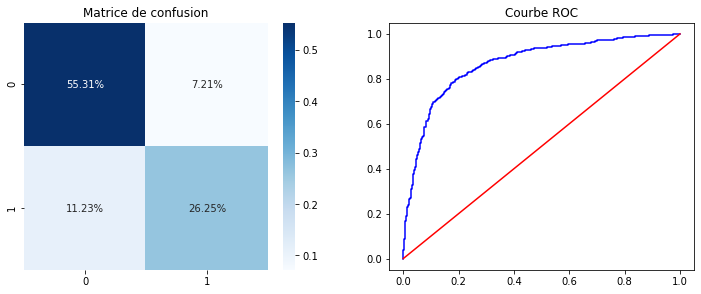

In [125]:
print ("Classification report :")
print(classification_report(labels, preds))
print ("Accuracy : ",accuracy_score(labels, preds))
cm = confusion_matrix(labels, preds)
ROC = roc_auc_score(labels, preds) 
print ("AUC : ", ROC)
fpr, tpr, thresholds = roc_curve(labels, scores)
plt.figure(figsize=(12, 10))
plt.subplot(221)
sns.heatmap(cm / np.sum(cm), annot=True, 
        fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
plt.subplot(222)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
plt.plot([0,1],[0,1],color='red')
plt.title('Courbe ROC')
plt.show()